/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: Runtim

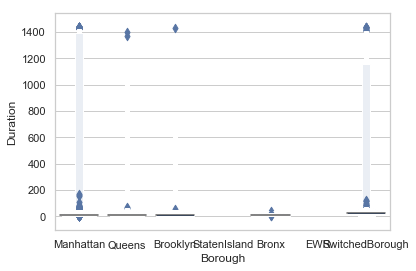

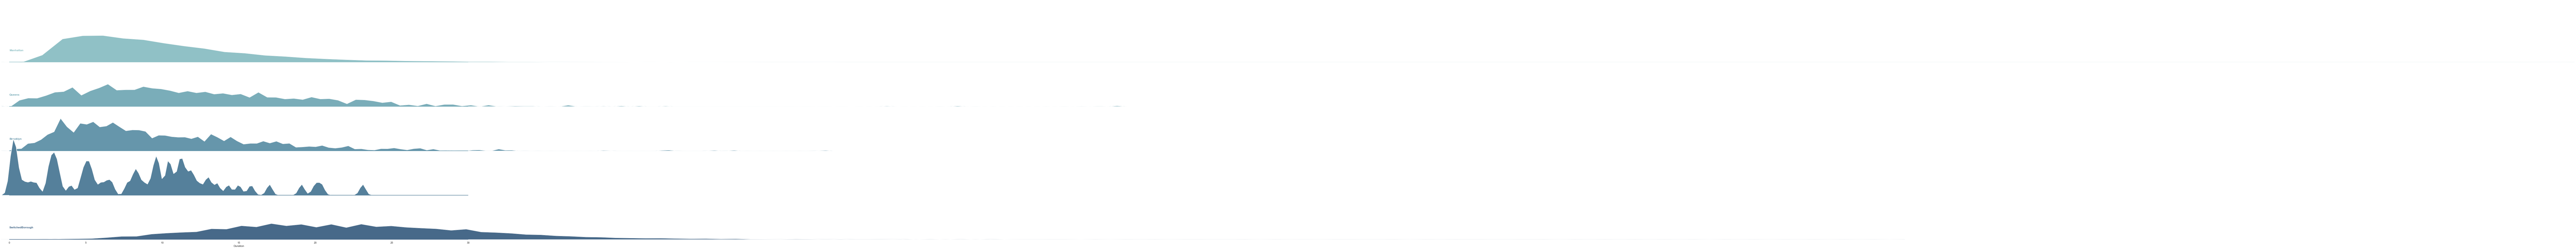

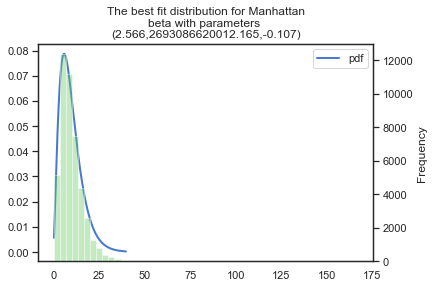

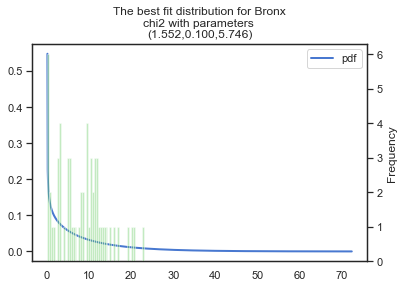

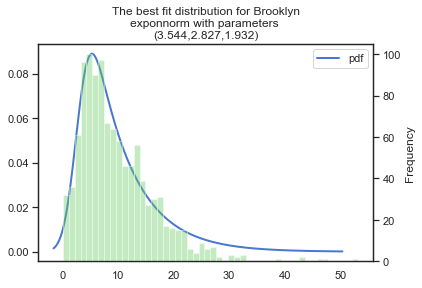

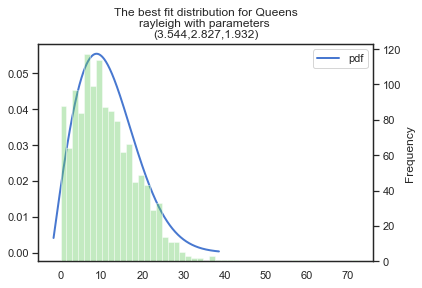

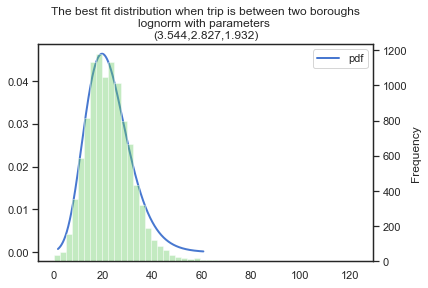

'Therefore, generally we got right skewed distribution when taxi is in same borough. Data is right skewed\nbecause generally people make short trips in NY. However if you switch your borough, there should be pile up.\nAveragely It takes half an hour. '

In [2]:
import pandas as pd
import numpy as np 

dur_loc = pd.DataFrame()
duration_min = pd.Series()
PULocationID = pd.Series()
DOLocationID = pd.Series()

buffer = 10000

for month in ['01','02','03','04','05','06']: #['01']  ['01','02','03','04','05','06']
    for chunk in pd.read_csv("/Users/ince/Desktop/uni/adm/hws/hw2/yellow_tripdata_2018-"+month+".csv", chunksize=buffer, nrows=10000):
                
        date_tmp_pickup = pd.to_datetime(chunk['tpep_pickup_datetime'], format="%Y-%m-%d %H:%M:%S")
        date_tmp_dropoff = pd.to_datetime(chunk['tpep_dropoff_datetime'], format="%Y-%m-%d %H:%M:%S")
        #x = pd.to_datetime("2/1/2018 0:44", format="%d/%m/%Y %H:%M")-pd.to_datetime("1/1/2018 23:34", format="%d/%m/%Y %H:%M")
        
        duration_min = duration_min.append(round((date_tmp_dropoff-date_tmp_pickup).dt.total_seconds()/60,1))
        PULocationID = PULocationID.append(chunk['PULocationID'])
        DOLocationID = DOLocationID.append(chunk['DOLocationID'])


dur_loc['duration_min'] = duration_min
dur_loc['PULocationID'] = PULocationID
dur_loc['DOLocationID'] = DOLocationID
dur_loc.dropna(inplace=True)      


zone_lookup = pd.read_csv("/Users/ince/Desktop/uni/adm/hws/hw2/taxi_zone_lookup.csv") #this dataset has a map btwn LocationID and Borough(ilçe)

#merge dur_loc and zone_lookup to get pick up borough
trips = dur_loc.merge(zone_lookup[['LocationID', 'Borough']], how='inner',
                      left_on='PULocationID',
                      right_on='LocationID').fillna("")[['duration_min','PULocationID','DOLocationID','Borough']]

trips.rename(columns= {'Borough':'PUBorough'}, inplace=True)

#merge trips and zone_lookup to get drop off borough
trips = trips.merge(zone_lookup[['LocationID', 'Borough']], how='inner',
                      left_on='DOLocationID',
                      right_on='LocationID').fillna("")[['duration_min','PULocationID','DOLocationID','PUBorough','Borough']]

trips.rename(columns= {'Borough':'DOBorough'}, inplace=True)


#take a look trips and try to see if there is weird data
trips.describe()

trips.drop(trips.index[np.where(trips['duration_min'] <= 0)], inplace=True) #drop if duration of trips is zero or less than zero

#trips[trips['duration_min']>1400] #there are some outliers also.


# set of all boroughs
Boroughs = list(set(zone_lookup['Borough']))
Boroughs[Boroughs.index('Staten Island')] = 'StatenIsland'
del Boroughs[Boroughs.index('Unknown')] 

# split data based on boroughs
Bronx = trips[(trips['PUBorough']==trips['DOBorough']) & (trips['PUBorough']=='Bronx')]['duration_min']
Brooklyn = trips[(trips['PUBorough']==trips['DOBorough']) & (trips['PUBorough']=='Brooklyn')]['duration_min']
EWR = trips[(trips['PUBorough']==trips['DOBorough']) & (trips['PUBorough']=='EWR')]['duration_min']
Manhattan = trips[(trips['PUBorough']==trips['DOBorough']) & (trips['PUBorough']=='Manhattan')]['duration_min']
Queens = trips[(trips['PUBorough']==trips['DOBorough']) & (trips['PUBorough']=='Queens')]['duration_min']
StatenIsland = trips[(trips['PUBorough']==trips['DOBorough']) & (trips['PUBorough']=='StatenIsland')]['duration_min']
SwitchedBorough = trips[trips['PUBorough']!=trips['DOBorough']]['duration_min']
#SwitchedBorough can be specified as finding the most frequest trip among 2 boroughs


#find and eliminate outliers for each borough since we have huge data, visialization will be easier in that way.
    
#for visual check, boxplot will be helpful;
import seaborn as sns
import matplotlib.pyplot as plt

#create a dataframe and collect together all boroughs to easily visialize them
df = pd.DataFrame()
for B in Boroughs:
    df2 = eval("pd.DataFrame({'Duration':" + B +",'Borough':['"+str(B)+"']*len("+B+")})")
    df = pd.concat([df, df2])

df = pd.concat([df, pd.DataFrame({'Duration':SwitchedBorough,'Borough':['SwitchedBorough']*len(SwitchedBorough)})])

    
sns.set(style="whitegrid")

sns.boxenplot(x="Borough", y="Duration",
              color="b", order= Boroughs+['SwitchedBorough'],
              scale="linear", data=df)

"""it can be obviously seen that there are some outliers on data, especially for Manhattan, Bronx, Brooklyn
and Queens. Generally outliers are above 1400 minites. We may ignore them since we have too much data. Also
We can observe the distribution of data more effectively"""


"""z-score is for normalization. After normalized the data, 99.6 percent of data should be lie 
between -3 and 3. In the light of this information, if the some observations are out of that range,
they are outliers. """

#formal check by using z-score
from scipy import stats
threshold = 3 #the threshold is 3(we'll take absolute of it)

Bronx_z = np.abs(stats.zscore(Bronx))
Bronx.drop(Bronx.index[np.where(Bronx_z > 3)], inplace=True) #np.where(Bronx_z > 3)[0][0] BOŞ KÜME DE OLABİLİR?

Brooklyn_z = np.abs(stats.zscore(Brooklyn))
Brooklyn.drop(Brooklyn.index[np.where(Brooklyn_z > 3)], inplace=True) 

EWR_z = np.abs(stats.zscore(EWR))
EWR.drop(EWR.index[np.where(EWR_z > 3)], inplace=True)

Manhattan_z = np.abs(stats.zscore(Manhattan))
Manhattan.drop(Manhattan.index[np.where(Manhattan_z > 3)], inplace=True)

Queens_z = np.abs(stats.zscore(Queens))
Queens.drop(Queens.index[np.where(Queens_z > 3)], inplace=True)

StatenIsland_z = np.abs(stats.zscore(StatenIsland))
StatenIsland.drop(StatenIsland.index[np.where(StatenIsland_z > 3)], inplace=True)

SwitchedBorough_z = np.abs(stats.zscore(SwitchedBorough))
SwitchedBorough.drop(SwitchedBorough.index[np.where(SwitchedBorough_z > 3)], inplace=True)


#after getting rid of the outliers, create a dataframe again
df_wo_outliers = pd.DataFrame()
for B in Boroughs:
    df2 = eval("pd.DataFrame({'Duration':" + B +",'Borough':['"+str(B)+"']*len("+B+")})")
    df_wo_outliers = pd.concat([df_wo_outliers, df2])
df_wo_outliers = pd.concat([df_wo_outliers,
                            pd.DataFrame({'Duration':SwitchedBorough,'Borough':['SwitchedBorough']*len(SwitchedBorough)})])

#check visually again;

sns.set(style="whitegrid")

sns.boxenplot(x="Borough", y="Duration",
              color="b", order= Boroughs+['SwitchedBorough'],
              scale="linear", data=df_wo_outliers)

"""it is more clear now. According to boxplot, Manhattan has the most outliers. Inlike Manhattan, Bronx
has just one outlier. Median of the trip duration is similar for Manhattan, Bronx, Brooklyn and Queens.
Moreover in Manhattan, people tend to make short trips more. SwitchedBorough data spreads more because
generally it takes more time when you travel out of borough. That why it has also many outliers. """



#visiualization for all dist

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(8, rot=-.25, light=.7) #Make a sequential palette from the cubehelix system. bu renk seçiyo birinden öbürüne geçen bi skala ile
Borough = sns.FacetGrid(df_wo_outliers, row="Borough", hue="Borough", aspect=10, palette=pal,xlim=(0, 30)) #Multi-plot grid for plotting conditional relationships.
#burdaki row ve hue(bi de col var ama bunu kullanmadık burda):Variables that define subsets of the data, which will be drawn on separate facets in the grid. _order komutuyla sırasını belirleyebilirsin istersen
 

# Draw the densities in a few steps

# sns.FacetGrid() açıyosun ilk önce. boş bi zemine şablon oturttuğunu düşün. daha sonra .map() diyince çizdiriyosun detayları verip
#kde plot: Fit and plot a univariate or bivariate kernel density estimate.
Borough.map(sns.kdeplot, "Duration", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2) 
Borough.map(sns.kdeplot, "Duration", clip_on=False, color="w", lw=2, bw=.2)
Borough.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates--buna gerek yok
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


Borough.map(label, "Duration")

# Set the subplots to overlap
Borough.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
Borough.set_titles("")
Borough.set(yticks=[])
Borough.despine(bottom=True, left=True)

"""It is good prepreliminary preparation to have an idea about how all distributions look like. """

"""We may guess the which distribution can be good fit to our data but it is just a guess. Based on our
"instinct", we can check some distribution whether they are similar to our data or not. In order to
find that, some error calculation and graphically check will be used"""

import warnings
import scipy.stats as st
import statsmodels as sm
import matplotlib

"""After deeply understanding the steps,
the source: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1
will be used for taking help.

Empirically we'll try to fit some distribution to our data for each boroughs. Then the best parameters'll
find for the specified distribution. Sum of square error(SSE) will be used when the distributions are compared
to eachother. Thus, the distribution with minimum SSE will be the best fit.
"""

# Build a function to find best distribution that fit the data.
def bestDist(data, bins=200):
    # Get histogram of original data, according to number of bins, histogram function will create boundaries for bins based on its width
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0 #since there are 100 bins, we split the bins equally on x axis.
                   
    #in scipy, there are lots of distribution type but in here, we just try basic ones;
    DISTRIBUTIONS = [ st.beta,st.cauchy,st.chi2,st.expon,st.exponnorm,st.gamma,st.laplace,st.logistic,
                     st.lognorm,st.norm,st.pareto,st.rayleigh,st.uniform ]
            
    # Best holders; just for the inital step, we assign some samples
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
        
    # We try all distribution that we wrote above to estimate distribution parameters from our original data
    for dist in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
        
                # fit dist to data
                prms = dist.fit(data) #fit helps to find best prm.s for the data
        
                #Separate parts of parameters: we split location,scale parameter and arguments if they exist
                arg = prms[:-2]
                loc = prms[-2]
                scale = prms[-1]
        
                """After finding best parameters for the specified distribution, we'll calculate fitted pdf
                and sse(sum of square error)"""
                pdf = dist.pdf(x, loc=loc, scale=scale, *arg) #it generates pdf from x; remember that we generate x from our original data to fit the histogram
                sse = np.sum(np.power(y - pdf, 2)) #sum of square error. this is our decision criteria
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass
        
                # Update best holders for the distribution and its parameters according to sse.
                if best_sse > sse > 0:
                    best_dist = dist
                    best_prms = prms
                    best_sse = sse
        
        except Exception:
            pass
    return (best_dist.name, best_prms)

# Store the best distribution and its parameters, then we'll use them to get pdf
    
def pdf(best_dist, best_prms, size=1000):
    # Separate parts of parameters
    arg = best_prms[:-2]
    loc = best_prms[-2]
    scale = best_prms[-1]

    # Get sane start and end points of distribution
    """ppf:Percent point function (inverse of cdf — percentiles)
       we use start end point to split x axis based on percentiles. 0.001 means it will almost start from
       0th index and it goes until reach almost 100th percentile (0.999 represents that)"""
    #if arg doesn't exist we just use location and scale prm.s, otherwise we use tree of them.
    start = best_dist.ppf(0.001, *arg, loc=loc, scale=scale) if arg else best_dist.ppf(0.001, loc=loc, scale=scale)
    end = best_dist.ppf(0.999, *arg, loc=loc, scale=scale) if arg else best_dist.ppf(0.999, loc=loc, scale=scale)

    # Now we can create pdf
    x = np.linspace(start, end, size) #.linspace() returns evenly spaced numbers over a specified interval
    y = best_dist.pdf(x, loc=loc, scale=scale, *arg) 
    pdf = pd.Series(y, x)
    return pdf


#Let's try it for all boroughs
    
# Manhattan;
Man_best_fit_name, Man_best_fit_prms = bestDist(Manhattan, bins=200)
Man_best_dist = getattr(st, Man_best_fit_name) #getattr() returns the value of the named attribute of an object

Man_pdf = pdf(Man_best_dist, Man_best_fit_prms)

Man_prm = list(map(lambda x: "%.3f" % x, Man_best_fit_prms)) #for the title round the parameters

#Let's check on histogram and line of pdf
sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots()
Man_pdf.plot(lw=2, label='pdf', legend=True, ax=ax)
ax2 = ax.twinx()
sns.distplot(Manhattan, bins=50,kde=False, color="g", ax=ax2)

plt.xlabel(u'Duration (min)')
plt.ylabel("Frequency")
plt.title(u'The best fit distribution for Manhattan\n'+Man_best_fit_name+' with parameters \n' 
          +'('+Man_prm[0]+','+Man_prm[1]+','+Man_prm[2]+')') # You can comment this line out if you don't need title
plt.show(fig)

"""It seems beta distribution totally fit the Manhattan taxi travel duration. Also lognormal distribution is another good option with different parameters of course. """



# Bronx
Brnx_best_fit_name, Brnx_best_fit_prms = bestDist(Bronx, bins=100)
Brnx_best_dist = getattr(st, Brnx_best_fit_name) #getattr() returns the value of the named attribute of an object

Brnx_pdf = pdf(Brnx_best_dist, Brnx_best_fit_prms)

Brnx_prm = list(map(lambda x: "%.3f" % x, Brnx_best_fit_prms)) #for the title round the parameters

#Let's check on histogram and line of pdf
sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots()
Brnx_pdf.plot(lw=2, label='pdf', legend=True, ax=ax)
ax2 = ax.twinx()
sns.distplot(Bronx, bins=50,kde=False, color="g", ax=ax2)

plt.xlabel(u'Duration (min)')
plt.ylabel("Frequency")
plt.title(u'The best fit distribution for Bronx\n'+Brnx_best_fit_name+' with parameters \n' 
          +'('+Brnx_prm[0]+','+Brnx_prm[1]+','+Brnx_prm[2]+')') # You can comment this line out if you don't need title
plt.show(fig)

"""This time the distribution almost fit the Bronx taxi travel duration. But if we compare with
Manhattan, this one is close to fit it. """ 



# Brooklyn
Bklyn_best_fit_name, Bklyn_best_fit_prms = bestDist(Brooklyn, bins=200)
Bklyn_best_dist = getattr(st, Bklyn_best_fit_name) #getattr() returns the value of the named attribute of an object

Bklyn_pdf = pdf(Bklyn_best_dist, Bklyn_best_fit_prms)

Bklyn_prm = list(map(lambda x: "%.3f" % x, Bklyn_best_fit_prms)) #for the title round the parameters

#Let's check on histogram and line of pdf
sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots()
Bklyn_pdf.plot(lw=2, label='pdf', legend=True, ax=ax)
ax2 = ax.twinx()
sns.distplot(Brooklyn, bins=50,kde=False, color="g", ax=ax2)

plt.xlabel(u'Duration (min)')
plt.ylabel("Frequency")
plt.title(u'The best fit distribution for Brooklyn\n'+Bklyn_best_fit_name+' with parameters \n' 
          +'('+Bklyn_prm[0]+','+Bklyn_prm[1]+','+Bklyn_prm[2]+')') # You can comment this line out if you don't need title
plt.show(fig)

"""Exponential normal distribution, it is also called exponentially modified Gaussian (EMG) distribution,
is the most close one to Brooklyn taxi travel duration data.
When we try more small data of Brooklyn lognormal also fit it. But we are trying to find best fit. 
So, It seems perfect for our data. In addition to Manhattan, Brooklyn is also good example for 
estimating distribution. """ 




# Queens
Qns_best_fit_name, Qns_best_fit_prms = bestDist(Queens, bins=200)
Qns_best_dist = getattr(st, Qns_best_fit_name) #getattr() returns the value of the named attribute of an object

Qns_pdf = pdf(Qns_best_dist, Qns_best_fit_prms)

Qns_prm = list(map(lambda x: "%.3f" % x, Bklyn_best_fit_prms)) #for the title round the parameters

#Let's check on histogram and line of pdf
sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots()
Qns_pdf.plot(lw=2, label='pdf', legend=True, ax=ax)
ax2 = ax.twinx()
sns.distplot(Queens, bins=50,kde=False, color="g", ax=ax2)

plt.xlabel(u'Duration (min)')
plt.ylabel("Frequency")
plt.title(u'The best fit distribution for Queens\n'+Qns_best_fit_name+' with parameters \n' 
          +'('+Qns_prm[0]+','+Qns_prm[1]+','+Qns_prm[2]+')') # You can comment this line out if you don't need title
plt.show(fig)

"""Since the Queens data does not has smooth distribution, the distribution that we guess is not perfectly fit it.
There are many rises and falls. Generally rayleigh and exponentially normal distribution can be good options. We may say that
Queens is about to fit it. """ 


"""EWR and Staten Island data are not too much. So no need to estimate their distribution. For example,
EWR is 28 observations and we don't have any data for Staten Island. """



"""The last one is SwitchedBorough. That means we'll examine if the taxi goes from the borough to
another borough. We expect that duration of trips will be long all the time. Hence, most probably
we get more close to belly shape because this time, unlike the trips inside the borough, we have data for long trips also.
It is expected that it is not right tailed distribution"""

# SwitchedBorough
SBoro_best_fit_name, SBoro_best_fit_prms = bestDist(SwitchedBorough, bins=200)
SBoro_best_dist = getattr(st, SBoro_best_fit_name) #getattr() returns the value of the named attribute of an object

SBoro_pdf = pdf(SBoro_best_dist, SBoro_best_fit_prms)

SBoro_prm = list(map(lambda x: "%.3f" % x, Bklyn_best_fit_prms)) #for the title round the parameters

#Let's check on histogram and line of pdf
sns.set(style="white", palette="muted", color_codes=True)

fig, ax = plt.subplots()
SBoro_pdf.plot(lw=2, label='pdf', legend=True, ax=ax)
ax2 = ax.twinx()
sns.distplot(SwitchedBorough, bins=50,kde=False, color="g", ax=ax2)

plt.xlabel(u'Duration (min)')
plt.ylabel("Frequency")
plt.title(u'The best fit distribution when trip is between two boroughs\n'+SBoro_best_fit_name+' with parameters \n' 
          +'('+SBoro_prm[0]+','+SBoro_prm[1]+','+SBoro_prm[2]+')') # You can comment this line out if you don't need title
plt.show(fig)

"""Since the trips are cumulated at some point, around 25 minutes, we got more belly shape distribution.
That make sense. Because it is easy to guess if you are switch the borough, it will take more time. So there
are no much data for short trip. Furthermore, the best fit distribution is also good fit for the data. """


"""Therefore, generally we got right skewed distribution when taxi is in same borough. Data is right skewed
because generally people make short trips in their own borough. However if you switch your borough, it is normal there is 
pile up and averagely it takes half an hour. """

